In [1]:
import yfinance as yf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from tda_m2r import *
import pandas as pd
from ripser import ripser, Rips
import persim
import gudhi
import requests
from datetime import datetime

In [2]:
# Collecting sufficient amount of tickers

# Disable SSL verification (not recommended for production)
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url, verify=False)  # Disable SSL verification
    tables = pd.read_html(response.text)
    sp500_tickers = tables[0]['Symbol'].tolist()
    return sp500_tickers

def get_russell1000_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_Russell_1000_companies'
    response = requests.get(url, verify=False)  # Disable SSL verification
    tables = pd.read_html(response.text)
    russell1000_tickers = tables[0]['Ticker'].tolist()
    return russell1000_tickers

def get_nasdaq_tickers():
    url = 'https://en.wikipedia.org/wiki/NASDAQ-100'
    response = requests.get(url, verify=False)  # Disable SSL verification
    tables = pd.read_html(response.text)
    nasdaq_tickers = tables[4]['Ticker'].tolist()
    return nasdaq_tickers

def get_dow_tickers():
    url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
    response = requests.get(url, verify=False)  # Disable SSL verification
    tables = pd.read_html(response.text)
    dow_tickers = tables[1]['Symbol'].tolist()
    return dow_tickers

# Fetch tickers from different sources
sp500_tickers = get_sp500_tickers()
nasdaq_tickers = get_nasdaq_tickers()
dow_tickers = get_dow_tickers()

# Combine and deduplicate tickers
all_tickers = list(set(sp500_tickers + nasdaq_tickers + dow_tickers))

# Select 200 unique tickers
selected_tickers = all_tickers[:500]

# Display the total number of unique tickers and the selected tickers
print(f"Total unique tickers: {len(selected_tickers)}")



/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_19459/472908719.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)
/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_19459/472908719.py:23: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


Total unique tickers: 500


/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_19459/472908719.py:30: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [3]:
# download tickers from above
data = yf.download(selected_tickers, start='2015-01-01', end='2021-12-31')

# Ensure the 'Date' column is a datetime type and set it as the index
data.index = pd.to_datetime(data.index)

data.head(5)
# Only need the adjusted close price for each ticker
data = data['Adj Close']

# Checking if the data frame is correctly set up.
data.head(5)


[**********************59%%**                    ]  294 of 500 completed

$BF.B: possibly delisted; No price data found  (1d 2015-01-01 -> 2021-12-31)


[*********************100%%**********************]  500 of 500 completed

8 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['CEG', 'VLTO', 'SOLV', 'GEV', 'GEHC', 'KVUE']: YFChartError("%ticker%: Data doesn't exist for startDate = 1420088400, endDate = 1640926800")
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2015-01-01 -> 2021-12-31)')


Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBRA,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.551193,51.079910,24.402174,44.314430,NaN,37.481441,19.496668,75.950912,72.339996,45.454941,...,101.781906,24.597055,127.992805,27.094418,61.023285,33.728859,43.460018,77.430000,NaN,40.470406
2015-01-05,36.847569,51.051483,23.714718,43.480476,NaN,37.489799,19.379999,74.668541,71.980003,44.628330,...,101.050812,24.597055,125.814384,26.786867,59.353561,31.629652,42.576984,76.339996,NaN,40.227467
2015-01-06,36.273552,50.255581,23.716959,43.265255,NaN,37.064056,19.423332,74.129944,70.529999,43.580746,...,100.548203,24.569811,123.130608,26.929394,59.038017,31.443636,42.054398,75.790001,NaN,39.834995
2015-01-07,36.754986,50.227165,24.049520,45.013889,NaN,37.364567,19.536667,75.685883,71.110001,44.039074,...,101.987518,24.644735,126.746719,27.161928,59.636219,31.691643,43.447987,77.720001,NaN,40.657303
2015-01-08,37.856712,50.843033,24.973558,45.484673,NaN,38.132553,19.876667,76.840042,72.919998,44.816574,...,103.152718,24.910395,128.271576,27.476986,60.628876,31.930805,44.204857,79.379997,NaN,41.283375


In [4]:
# Only include tickers that is already in the market start

# Selecting tickers that have market value on the first trading day of 2015
filter = [not pd.isna(value) for value in data.loc['2015-01-02']]

# Filtered out the unwanted tickers
df = data.loc[:, filter]

# we end up having 434 tickers

In [5]:
df.head(5)

Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,37.551193,51.079910,24.402174,44.314430,37.481441,19.496668,75.950912,72.339996,45.454941,39.839645,...,49.964764,101.781906,24.597055,127.992805,27.094418,61.023285,33.728859,43.460018,77.430000,40.470406
2015-01-05,36.847569,51.051483,23.714718,43.480476,37.489799,19.379999,74.668541,71.980003,44.628330,38.461121,...,49.275059,101.050812,24.597055,125.814384,26.786867,59.353561,31.629652,42.576984,76.339996,40.227467
2015-01-06,36.273552,50.255581,23.716959,43.265255,37.064056,19.423332,74.129944,70.529999,43.580746,37.702927,...,48.432091,100.548203,24.569811,123.130608,26.929394,59.038017,31.443636,42.054398,75.790001,39.834995
2015-01-07,36.754986,50.227165,24.049520,45.013889,37.364567,19.536667,75.685883,71.110001,44.039074,38.269657,...,49.217583,101.987518,24.644735,126.746719,27.161928,59.636219,31.691643,43.447987,77.720001,40.657303
2015-01-08,37.856712,50.843033,24.973558,45.484673,38.132553,19.876667,76.840042,72.919998,44.816574,37.710583,...,50.185081,103.152718,24.910395,128.271576,27.476986,60.628876,31.930805,44.204857,79.379997,41.283375


In [6]:
# z-score normalisation of for each column using sample standard deviation
for x in df:
    df[x] = (df[x] - df[x].mean()) / np.std(df[x], ddof=1)
    df[x] = df[x] - df[x].shift(1)

# remove first row of NaN values resulted from df[x].shift(1)
df = df.dropna()

df.head(10)

/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_19459/1324562965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = (df[x] - df[x].mean()) / np.std(df[x], ddof=1)
/var/folders/3m/33ltlvq53p9f6dd7pv5zd_g00000gn/T/ipykernel_19459/1324562965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = df[x] - df[x].shift(1)


Ticker,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.020458,-0.002389,-0.017070,-0.041071,0.000297,-0.017754,-0.018191,-0.002133,-0.023390,-0.168062,...,-0.006400,-0.017618,0.000000,-0.075413,-0.024156,-0.191979,-0.080842,-0.038514,-0.007301,-0.004798
2015-01-06,-0.016690,-0.066888,0.000056,-0.010599,-0.015115,0.006594,-0.007640,-0.008592,-0.029643,-0.092435,...,-0.007822,-0.012112,-0.006672,-0.092907,0.011194,-0.036280,-0.007164,-0.022793,-0.003684,-0.007751
2015-01-07,0.013998,-0.002388,0.008258,0.086117,0.010669,0.017247,0.022072,0.003437,0.012969,0.069093,...,0.007289,0.034685,0.018350,0.125183,0.018264,0.068779,0.009551,0.060783,0.012928,0.016239
2015-01-08,0.032034,0.051757,0.022944,0.023185,0.027266,0.051740,0.016372,0.010725,0.022000,-0.068159,...,0.008978,0.028080,0.065063,0.052787,0.024745,0.114132,0.009210,0.033012,0.011120,0.012364
2015-01-09,-0.008076,-0.130590,0.000665,-0.061276,-0.014226,-0.026377,-0.001213,-0.006400,-0.000927,-0.039215,...,-0.005333,-0.022023,-0.008342,0.055502,-0.026512,-0.009828,-0.023195,-0.003405,0.007770,0.001292
2015-01-12,-0.012921,-0.194292,-0.015296,-0.000661,0.011262,-0.009130,-0.003274,-0.004266,-0.012737,-0.056955,...,0.000800,-0.022023,0.008342,-0.017795,-0.018853,-0.133780,-0.026265,-0.014410,0.000804,-0.015316
2015-01-13,-0.015075,0.065295,0.005376,-0.062737,-0.021749,0.011667,0.003881,-0.003141,-0.014358,0.006535,...,0.005333,0.002753,0.020018,0.040723,0.017086,-0.024942,0.002729,-0.007860,0.012593,-0.011256
2015-01-14,-0.013190,-0.078833,-0.002328,0.010345,-0.009832,-0.013189,-0.012734,-0.003555,-0.000926,-0.077494,...,-0.007556,-0.021472,-0.041706,-0.036498,0.018853,-0.019652,-0.007504,0.002899,-0.008775,0.004060
2015-01-15,-0.028265,0.000000,-0.016515,-0.027031,-0.009832,0.011160,-0.007398,0.001778,-0.018064,-0.022409,...,-0.007111,-0.006057,-0.011680,-0.028659,0.018853,-0.058953,-0.008186,-0.022660,0.000335,-0.001661


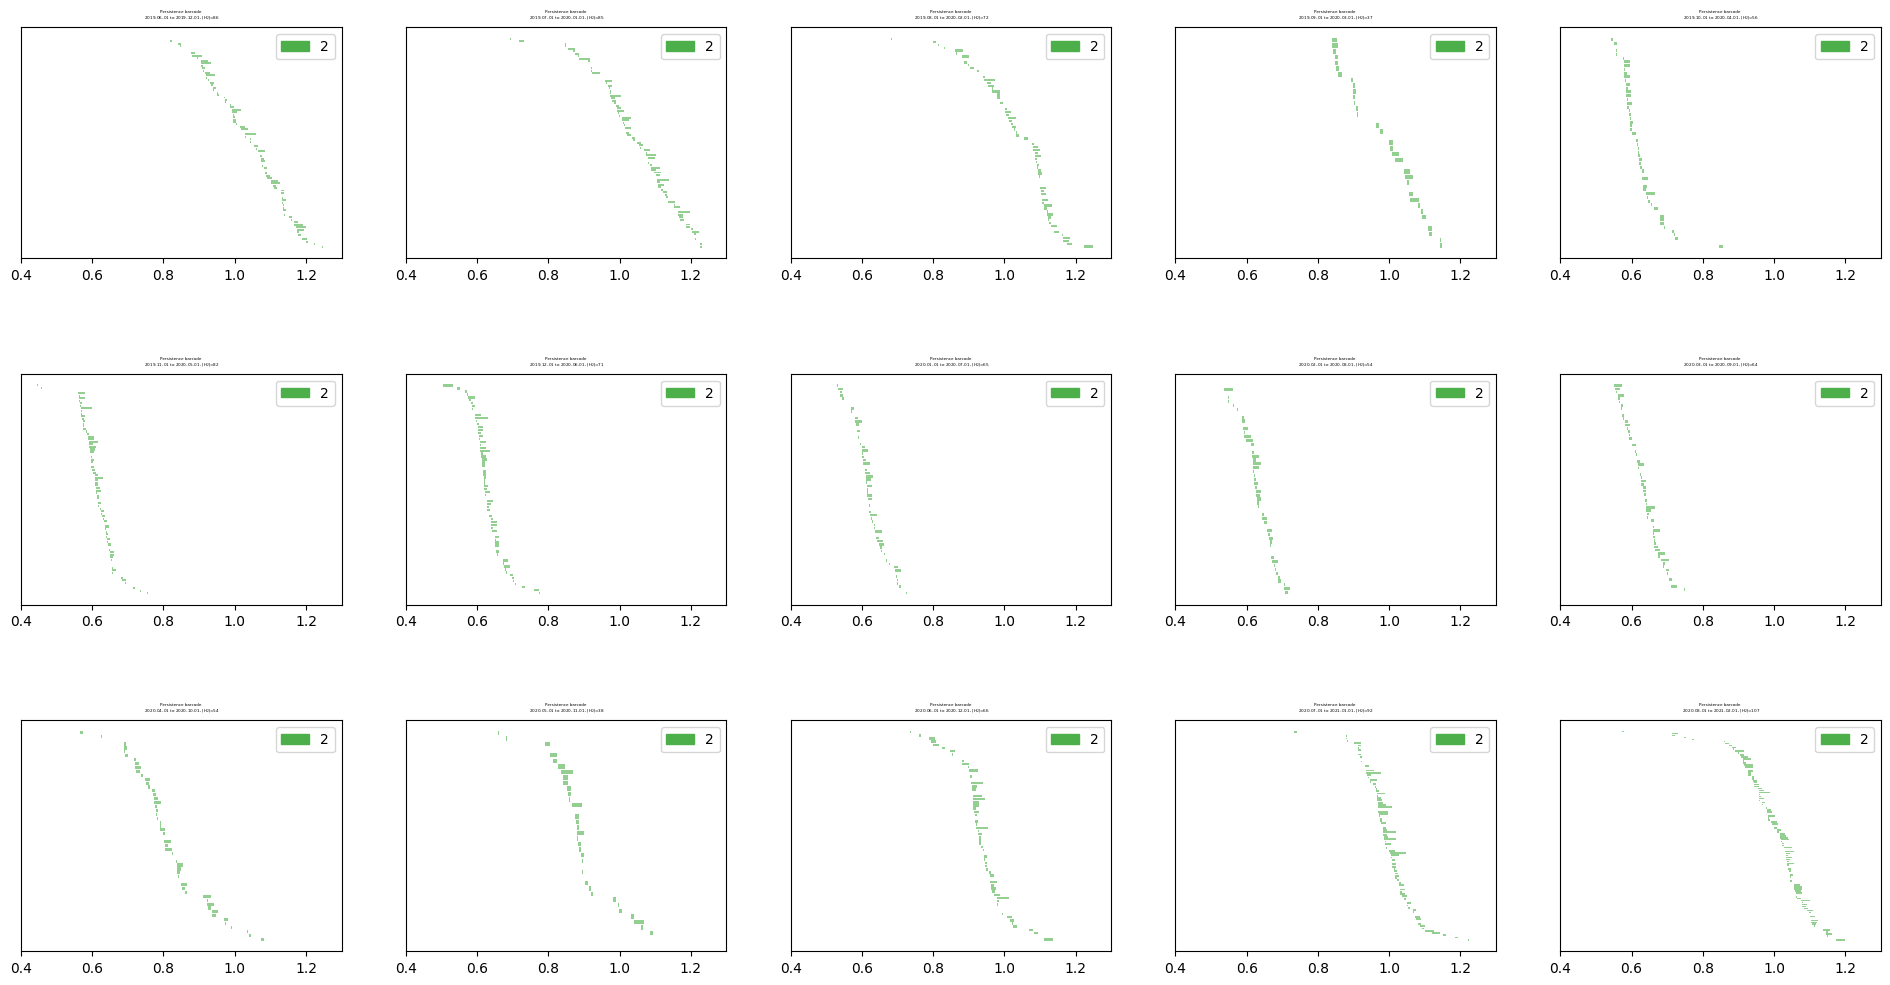

In [15]:
start_date_string = "2019-06-01"
period = 6
number_of_period = 15
subplot_row = 3
subplot_columns = 5
dim = 2


start_date =  datetime.strptime(start_date_string, "%Y-%m-%d")

start_dates = [start_date + pd.DateOffset(months=i) for i in range(number_of_period)]

fig, axs = plt.subplots(subplot_row, subplot_columns, figsize=(24, 12))

count = 0

for start_date in start_dates:
    end_date = start_date + pd.DateOffset(months=period)

    data_6months = df[start_date:end_date]

    # computing correlation matrix of the 6 months period
    data_6months_corr = data_6months.corr()
    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=dim, distance_matrix=True)['dgms']
    gd_barcode(barcode[dim], dim=dim, axes=axs[count//subplot_columns, count % subplot_columns])

    axs[count//subplot_columns, count % subplot_columns].set_xlim(0.4, 1.3)
    axs[count//subplot_columns, count % subplot_columns].set_title(f"Persistence barcode \n {str(start_date).split()[0]} to {str(end_date).split()[0]}, $|H_{dim}|$={len(barcode[dim])}", fontsize = 3)
    
    count += 1
    plt.subplots_adjust(hspace=0.5)


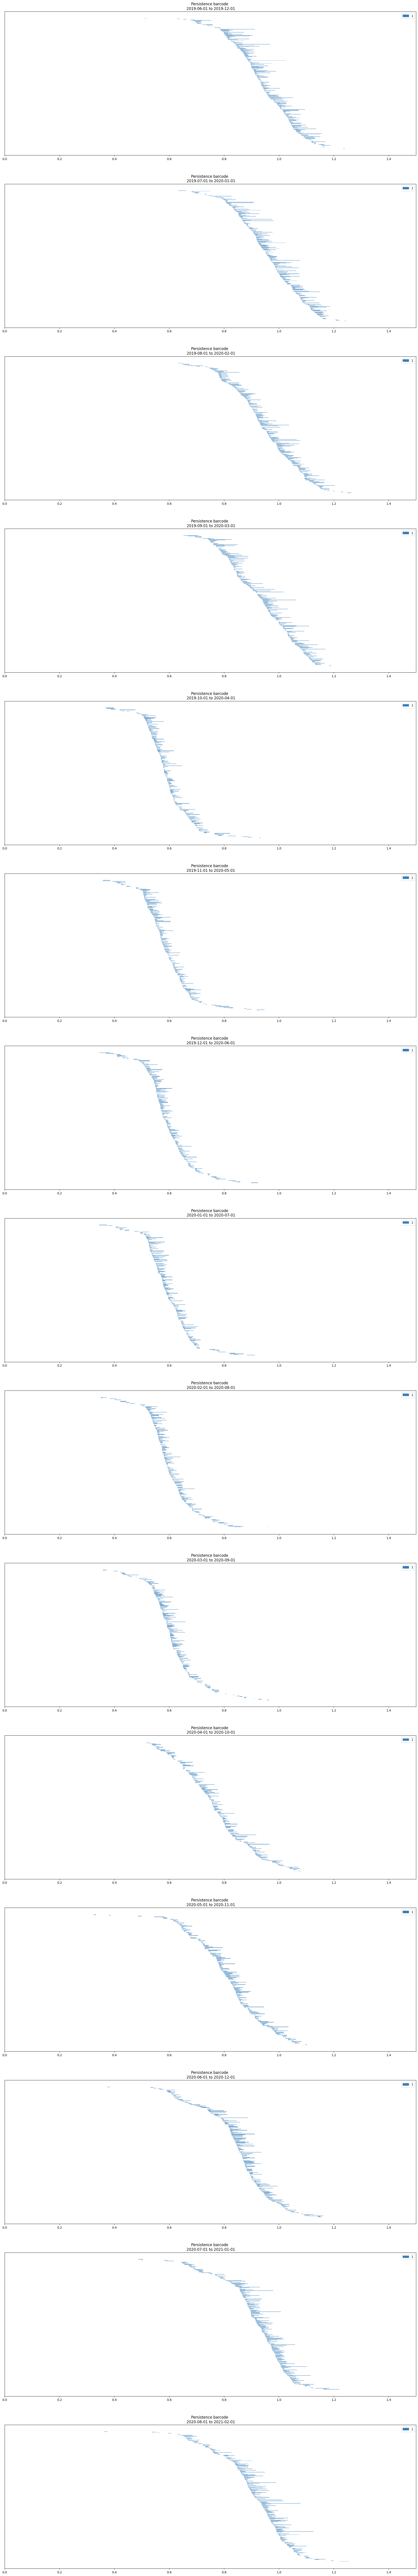

In [ ]:
start_date =  datetime.strptime("2019-06-01", "%Y-%m-%d")

start_dates = [start_date + pd.DateOffset(months=i) for i in range(15)]

fig, axs = plt.subplots(15, 1, figsize=(24, 150))

count = 0

for start_date in start_dates:
    end_date = start_date + pd.DateOffset(months=6)

    data_6months = df[start_date:end_date]

    # computing correlation matrix of the 6 months period
    data_6months_corr = data_6months.corr()
    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=1, distance_matrix=True)['dgms']

    gd_barcode(barcode[1], dim=1, axes=axs[count])
    axs[count].set_xlim(0, 1.5)
    axs[count].set_title(f"Persistence barcode \n {str(start_date).split()[0]} to {str(end_date).split()[0]}")
    count += 1


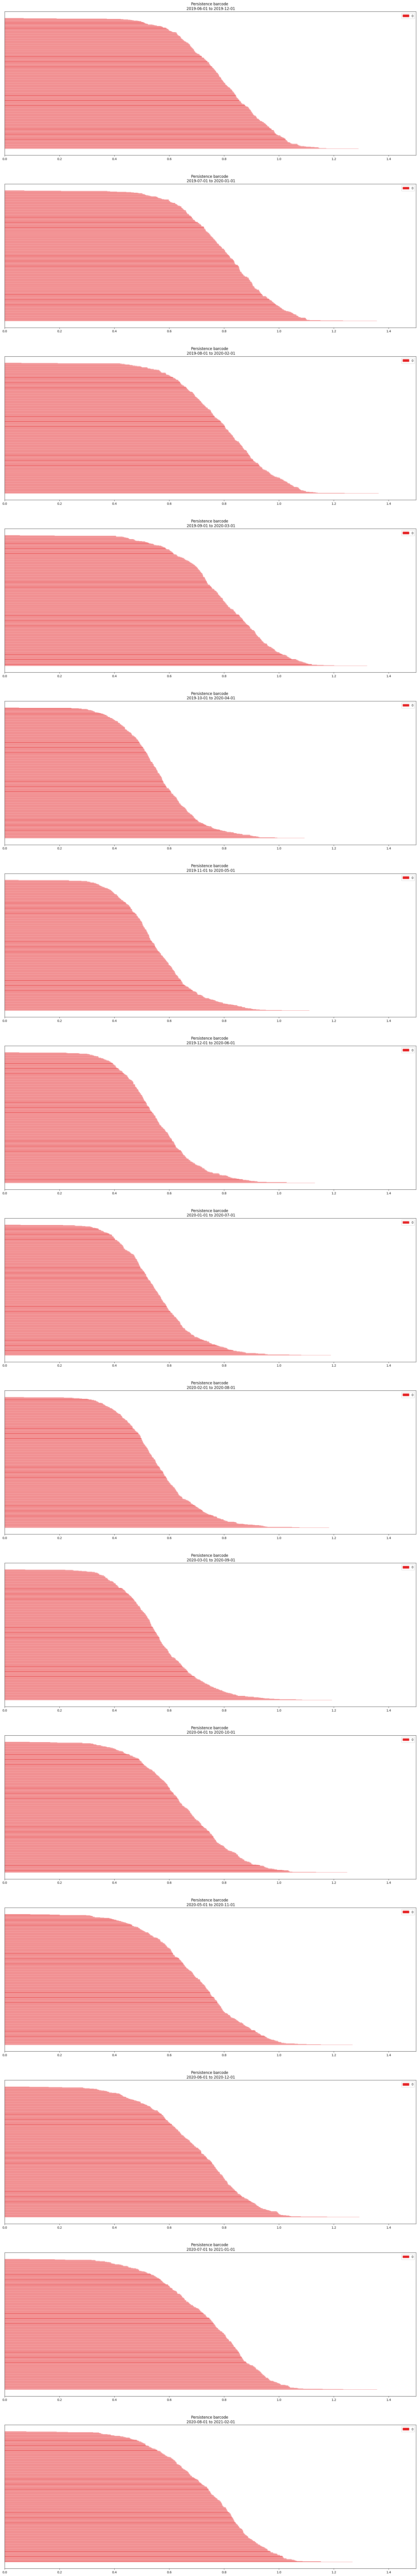

In [ ]:

start_date =  datetime.strptime("2019-06-01", "%Y-%m-%d")

start_dates = [start_date + pd.DateOffset(months=i) for i in range(15)]

fig, axs = plt.subplots(15, 1, figsize=(24, 150))

count = 0

for start_date in start_dates:
    end_date = start_date + pd.DateOffset(months=6)

    data_6months = df[start_date:end_date]

    # computing correlation matrix of the 6 months period
    data_6months_corr = data_6months.corr()
    data_corr = np.sqrt(2 * (1 - data_6months_corr.values))

    barcode = ripser(data_corr, maxdim=0, distance_matrix=True)['dgms']

    gd_barcode(barcode[0], dim=0, axes=axs[count])
    axs[count].set_xlim(0, 1.5)
    axs[count].set_title(f"Persistence barcode \n {str(start_date).split()[0]} to {str(end_date).split()[0]}")
    count += 1


In [19]:
len([x for x in df])

463